In [99]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [100]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp AND timestamp < '2021-03-06 04:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [101]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df

,timestamp,compound,sma,ema
timestamp,,,,
2021-01-26 16:00:00,2021-01-26 16:00:00,None,0.4150,0.0698
2021-01-26 17:00:00,2021-01-26 17:00:00,None,0.4150,0.0698
2021-01-26 18:00:00,2021-01-26 18:00:00,None,0.4150,0.0698
2021-01-26 19:00:00,2021-01-26 19:00:00,-0.1484,0.3775,-0.0586
2021-01-26 20:00:00,2021-01-26 20:00:00,-0.9993,0.2914,-0.4392
...,...,...,...,...
2021-03-05 23:00:00,2021-03-05 23:00:00,None,0.1057,0.1552
2021-03-06 00:00:00,2021-03-06 00:00:00,None,0.1057,0.1552
2021-03-06 01:00:00,2021-03-06 01:00:00,0.9968,0.2171,0.3923


In [102]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=61)).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 16:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

data = get_latest_prices('BTC')
data.index = data.time

<ipython-input-102-5595f8aaaa01>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


# Data Preprocessing

In [103]:
dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)
dataset_train = dataset_train.drop(columns=['open', 'high', 'low', 'volume', 'quoteVolume', 'btcVolume', 'usdVolume','time','timestamp','compound'])
dataset_train = dataset_train.dropna()
dataset_train['time'] = dataset_train.index
dataset_train

,close,sma,ema,time
time,,,,
2021-01-26 16:00:00,31985.30,0.4150,0.0698,2021-01-26 16:00:00
2021-01-26 17:00:00,32184.36,0.4150,0.0698,2021-01-26 17:00:00
2021-01-26 18:00:00,32224.50,0.4150,0.0698,2021-01-26 18:00:00
2021-01-26 19:00:00,32208.33,0.3775,-0.0586,2021-01-26 19:00:00
2021-01-26 20:00:00,31986.99,0.2914,-0.4392,2021-01-26 20:00:00
...,...,...,...,...
2021-03-05 22:00:00,49061.76,0.1057,0.1552,2021-03-05 22:00:00
2021-03-05 23:00:00,48751.71,0.1057,0.1552,2021-03-05 23:00:00
2021-03-06 00:00:00,48808.05,0.1057,0.1552,2021-03-06 00:00:00


In [134]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[0:3]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train.index)
datelist_train = [dt.datetime.strftime(date, '%Y-%m-%d %H:00:00') for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (729, 3)
All timestamps == 729
Featured selected: ['close', 'sma', 'ema']


In [135]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (729, 3).


array([[3.198530e+04, 4.150000e-01, 6.980000e-02],
       [3.218436e+04, 4.150000e-01, 6.980000e-02],
       [3.222450e+04, 4.150000e-01, 6.980000e-02],
       ...,
       [4.880805e+04, 1.057000e-01, 1.552000e-01],
       [4.864738e+04, 2.171000e-01, 3.923000e-01],
       [4.865772e+04, 1.141000e-01, 9.170000e-02]])

In [136]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.5107312 ],
       [-1.48499737],
       [-1.47980821],
       [-1.48189861],
       [-1.51051272],
       [-1.51049463],
       [-1.41396627],
       [-1.44835905],
       [-1.46543263],
       [-1.49789402],
       [-1.53438109],
       [-1.534575  ],
       [-1.52636593],
       [-1.57302837],
       [-1.55149474],
       [-1.54201229],
       [-1.61585775],
       [-1.61211648],
       [-1.58938317],
       [-1.68477001],
       [-1.66925939],
       [-1.73179443],
       [-1.82256609],
       [-1.72567834],
       [-1.69892323],
       [-1.70089211],
       [-1.80490172],
       [-1.67167686],
       [-1.57085781],
       [-1.6435372 ],
       [-1.70016946],
       [-1.72004963],
       [-1.68052844],
       [-1.65336998],
       [-1.64047075],
       [-1.58584745],
       [-1.59923018],
       [-1.54384415],
       [-1.56512051],
       [-1.61606201],
       [-1.62899744],
       [-1.57774697],
       [-1.57472448],
       [-1.58156581],
       [-1.57631976],
       [-1

In [137]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (580, 90, 2).
y_train shape == (580, 1).


# Create Model

In [138]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [139]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [140]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
2/2 [==============================] - 6s 3s/step - loss: 0.6470 - val_loss: 0.4466

Epoch 00001: val_loss improved from inf to 0.44659, saving model to weights.h5
Epoch 2/30
2/2 [==============================] - 0s 176ms/step - loss: 0.1777 - val_loss: 0.4210

Epoch 00002: val_loss improved from 0.44659 to 0.42098, saving model to weights.h5
Epoch 3/30
2/2 [==============================] - 0s 169ms/step - loss: 0.1442 - val_loss: 0.3665

Epoch 00003: val_loss improved from 0.42098 to 0.36645, saving model to weights.h5
Epoch 4/30
2/2 [==============================] - 0s 163ms/step - loss: 0.1074 - val_loss: 0.3182

Epoch 00004: val_loss improved from 0.36645 to 0.31822, saving model to weights.h5
Epoch 5/30
2/2 [==============================] - 0s 170ms/step - loss: 0.1024 - val_loss: 0.3126

Epoch 00005: val_loss improved from 0.31822 to 0.31262, saving model to weights.h5
Epoch 6/30
2/2 [==============================] - 0s 168ms/step - loss: 0.1011 - val_loss: 0.3284

In [146]:
datelist_train[-1]

'2021-03-06 03:00:00'

# Make future predictions

In [153]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(end=datelist_train[-1], periods=n_future, freq='H').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [154]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [157]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d %H:%M'), '%Y%m%d %H:%M')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series()

PREDICTION_TRAIN.head(3)

,close
2021-02-05 18:00:00,39630.816406
2021-02-05 19:00:00,39673.492188
2021-02-05 20:00:00,39717.750000


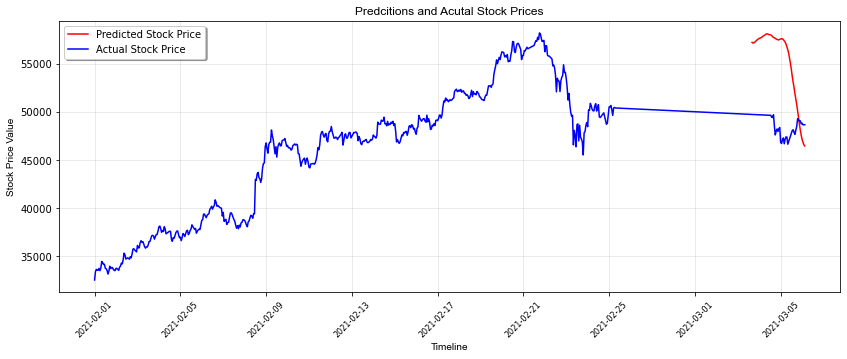

In [164]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-02-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['close'], color='r', label='Predicted Stock Price')
#plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['close'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['close'], color='b', label='Actual Stock Price')

#plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [160]:
PREDICTIONS_FUTURE.index

DatetimeIndex(['2021-03-03 16:00:00', '2021-03-03 17:00:00',
               '2021-03-03 18:00:00', '2021-03-03 19:00:00',
               '2021-03-03 20:00:00', '2021-03-03 21:00:00',
               '2021-03-03 22:00:00', '2021-03-03 23:00:00',
               '2021-03-04 00:00:00', '2021-03-04 01:00:00',
               '2021-03-04 02:00:00', '2021-03-04 03:00:00',
               '2021-03-04 04:00:00', '2021-03-04 05:00:00',
               '2021-03-04 06:00:00', '2021-03-04 07:00:00',
               '2021-03-04 08:00:00', '2021-03-04 09:00:00',
               '2021-03-04 10:00:00', '2021-03-04 11:00:00',
               '2021-03-04 12:00:00', '2021-03-04 13:00:00',
               '2021-03-04 14:00:00', '2021-03-04 15:00:00',
               '2021-03-04 16:00:00', '2021-03-04 17:00:00',
               '2021-03-04 18:00:00', '2021-03-04 19:00:00',
               '2021-03-04 20:00:00', '2021-03-04 21:00:00',
               '2021-03-04 22:00:00', '2021-03-04 23:00:00',
               '2021-03-